# Poster: OOI Assets & Datasets
#### Author: Andrew Reed, OOI - Coastal & Global Scale Nodes, WHOI

### Purpose
This notebook outlines the data used to produce the poster "OOI Assets & Datasets" presented at the OOI Facilities Board 2022 Northeast Pacific Community Workshop Meeting June 6-9, Portland, Oregon. 

### Data
Seawater pCO2 and pH from the NOAA PMEL buoy deployed at Ocean Station Papa were downloaded from NCEI [1]. Additionally, and meterological measurments from the NOAA PMEL mooring at Ocean Station Papa were were downloaded directly from the NOAA PMEL Ocean Climate Stations website [2]. Seawater pH, dissolved oxygen, chlorophyll-a, and CTD data from the Ocean Observatories Initiative Global Station Papa Flanking Moorings A & B and Apex Hybrid Profiling Mooring were utilized for this poster [3-6]. Additionally, discrete water samples of the carbon system collected by OOI during deployment/recovery of assets were were downloaded from the OOI Alfresco Web Document server [7]. Additionally information on the individual labs and their methods with respect to the discrete analysis are contained in READMEs in each cruise.

The OOI data were downloaded, processed, and combined into a unified dataset utilizing the ```Download_Data.ipynb``` jupyter notebook in this repository. Similarly, the bottle carbon data were prepared using the ```Bottle_Data.ipynb``` notebook. These should be run prior to this script in order to recreate the poster figures.


### Citations
1. Sutton, Adrienne J.; Sabine, Christopher L.; Dietrich, Colin; Maenner Jones, Stacy; Musielewicz, Sylvia; Bott, Randy; Osborne, John (2012). High-resolution ocean and atmosphere pCO2 time-series measurements from mooring Papa_145W_50N in the North Pacific Ocean (NCEI Accession 0100074). [2015-2021]. NOAA National Centers for Environmental Information. Dataset. https://doi.org/10.3334/cdiac/otg.tsm_papa_145w_50n. Accessed 2022-05-19.
2. Ocean Climate Stations - Pacific Marine Environmental Laboratory Ocean Station Papa Mooring 50.1$^{\circ}$N, 144.9$^{\circ}$W. Air temperature, barometric pressure, and wind speed data for 2008 to 2022. https://www.pmel.noaa.gov/ocs/data/disdel/. Accessed 2022-05-19.
3. NSF Ocean Observatories Initiative. (2022-06-07). Dissolved oxygen data from Global Station Papa Flanking Moorings and Upper Hybrid Wire Following Profiler from from 2015-01-01 to 2022-01-01. Data Portal. http://ooinet.oceanobservatories.org. Accessed on 2022-05-19.
4.  NSF Ocean Observatories Initiative. (2022-06-07). CTD data from Global Station Papa Apex Profiler Mooring (GP02HYPM-WFP02-04-CTDPFL000) from 2015-01-01 to 2022-01-01. Data Portal. http://ooinet.oceanobservatories.org. Accessed on 2022-05-19.
5.  NSF Ocean Observatories Initiative. (2022-06-07). Chlorophyll, Fluorescence, turbidity data from Global Station Papa Flanking Moorings from 2015-01-01 to 2022-01-01. Data Portal. http://ooinet.oceanobservatories.org. Accessed on 2022-05-19.
6.  NSF Ocean Observatories Initiative. (2022-06-07). Seawater pH data from Global Station Papa Flanking Moorings from 2015-01-01 to 2022-01-01. Data Portal. http://ooinet.oceanobservatories.org. Accessed on 2022-05-19.
7.  NSF Ocean Observatories Initiative. (2022-06-07). Discrete water sampling data from Global Station Papa from 2013 to 2018. Alfresco. https://alfresco.oceanobservatories.org. Accessed on 2022-05-19.

In [1]:
import importlib
import os
import numpy as np
import pandas as pd
import xarray as xr
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
%matplotlib inline

---
## Figure 3: Integrating Datasets
This figure is an example of integrating different physical and biogeochemical datasets from different sources to address potential questions for some of the major science themes. (Top) NOAA PMEL’s surface buoy met measurements; (Middle) Seawater pH from both OOI Flanking Moorings and PMEL buoy along with discrete bottle measurements; (Bottom) Chlorophyll-a concentrations from OOI Flanking Moorings.

This figure utilizes data from NOAA's PMEL buoy, including met wind speed data and surface seawater pH data, as well as pH and chlorophyll data from the OOI Global Ocean Station Papa Flanking Moorings A and B. It also uses discrete water sampling bottle data, which is collected during deployment/recovery of OOI moorings.

### NOAA PMEL Met Data

In [4]:
air_temperature = xr.open_dataset("../data/PMEL/airt50n145w_hr.cdf")
barometric_pressure = xr.open_dataset("../data/PMEL/bp50n145w_hr.cdf")
wind = xr.open_dataset("../data/PMEL/w50n145w_hr.cdf")

Reorganize the datasets to keep only one-dimension

In [5]:
air_temperature = xr.open_dataset("../data/PMEL/airt50n145w_hr.cdf").squeeze(dim=["depth", "lat", "lon"])
barometric_pressure = xr.open_dataset("../data/PMEL/bp50n145w_hr.cdf").squeeze(dim=["depth", "lat", "lon"])
wind = xr.open_dataset("../data/PMEL/w50n145w_hr.cdf").squeeze(dim=["depth", "lat", "lon"])

Filter the data to keep only the good met data as defined by a quality flag of "2"

In [6]:
air_temperature = air_temperature.where(air_temperature.QAT_5021 == 2, drop=True)
barometric_pressure = barometric_pressure.where(barometric_pressure.QBP_5915 == 2, drop=True)
wind = wind.where((wind.QWS_5401 == 2) & (wind.QWD_5410 == 2), drop=True)

Initial plot of the available met data

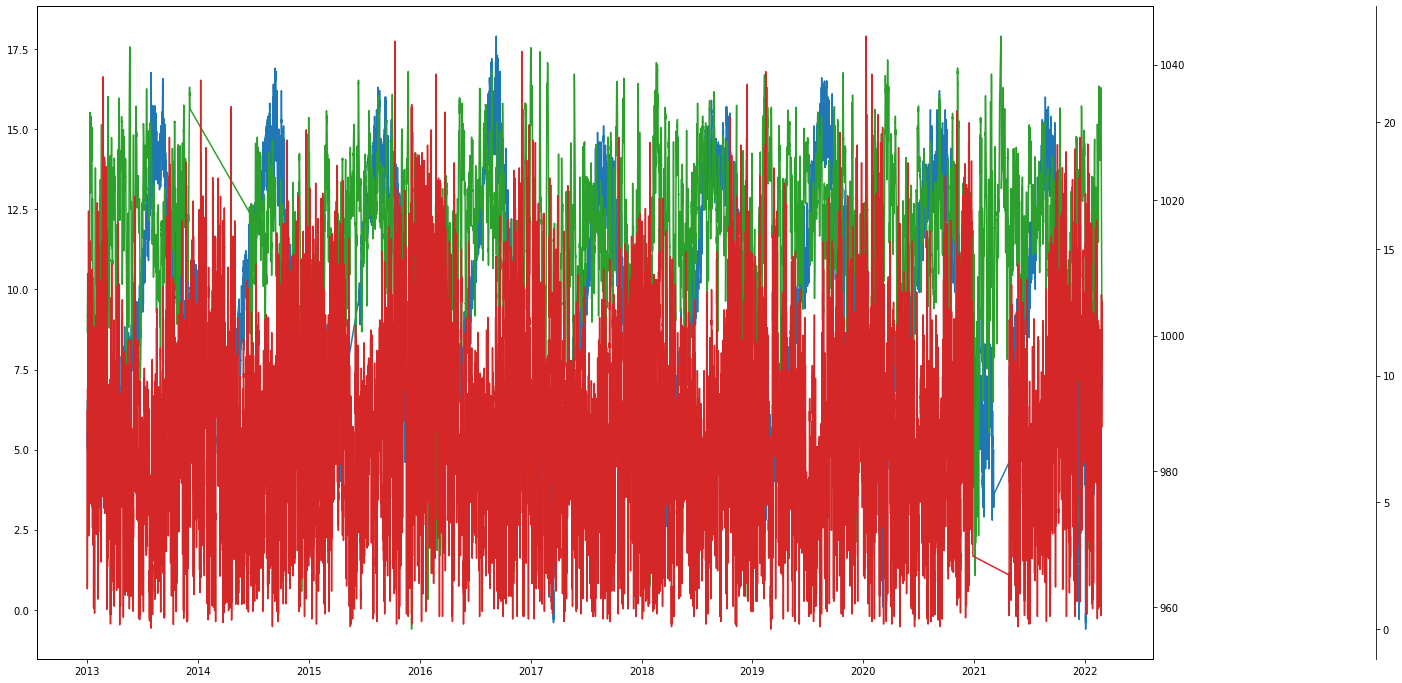

In [7]:
fig, ax = plt.subplots(figsize=(20, 12))

twin1 = ax.twinx()
twin2 = ax.twinx()

# Offset the right spine of twin2.  The ticks and label have already been
# placed on the right by twinx above.
twin2.spines.right.set_position(("axes", 1.2))

ax.plot(air_temperature["time"], air_temperature["AT_21"], color="tab:blue", label="Air Temperature")
twin1.plot(barometric_pressure["time"], barometric_pressure["BP_915"], color="tab:green", label="Barometric Pressure")
twin2.plot(wind["time"], wind["WS_401"], color="tab:red", label="Wind Speed")

#### Process Wind Data
Next, process the wind data to find periods where it is unusually windy, defined here as when wind speeds exceed 2 standard deviations of the monthly mean wind speeds, fitted using a two-cycle seasonal harmonic model.

In [26]:
def harmonic_interpolate(ds, param):
    """Interpolates harmonic data from monthly mean fits"""
    
    # Resample monthly means
    mu = ds[param].resample(time="M").mean()
    
    # Build the model to fit
    ts = mu.values
    f = 1/12
    N = len(ts)
    t_in = np.arange(0, N, 1)
    
    # Drop NaNs from the fitting
    mask = np.isnan(ts)
    ts = ts[mask == False]
    t_in = t_in[mask == False]
    n = len(t_in)
    
    # build the four-cycle model
    X = [np.ones(n), np.sin(2 * np.pi * f * t_in), np.cos(2 * np.pi * f * t_in),
         np.sin(4 * np.pi * f * t_in), np.cos(4 * np.pi * f * t_in),
         np.sin(6 * np.pi * f * t_in), np.cos(6 * np.pi * f * t_in),
         np.sin(8 * np.pi * f * t_in), np.cos(8 * np.pi * f * t_in)]
    
    # Calculate the regression
    [beta, resid, rank, s] = np.linalg.lstsq(np.transpose(X), ts, rcond=-1)
    regression = {
        "beta": beta,
        "residuals": resid,
        "rank": rank,
        "singular_values": s,
        "variance_explained": 1 - resid / sum((ts - ts.mean()) ** 2)
    }
    
    # Calculate the output
    N_out = len(ds[param])
    t_out = np.arange(0, N_out, 1)
    f_out = 1/(365*24)

    # Calculate the two-cycle fitted data
    fitted_data = beta[0] + beta[1]*np.sin(2*np.pi*f_out*t_out) + beta[2]*np.cos(
        2*np.pi*f_out*t_out) + beta[3]*np.sin(4*np.pi*f_out*t_out) + beta[4]*np.cos(4*np.pi*f_out*t_out)
    #fitted_data = pd.Series(fitted_data, index=ds.get_index("time"))
    
       
    # Return the fitted_data
    return fitted_data, regression


def standard_deviation(x, mu):
    n = len(x)
    deviations = (x - mu)**2
    variance = deviations.sum() / n
    std = np.sqrt(variance)
    return std

Process the wind speed data to get the data points are represent unusally wind conditions

In [27]:
# Identify when there we storms passing
wind_speed = wind["WS_401"].where(wind["QWS_5401"] == 2, drop=True)
# Select data since 2016
wind_speed = wind_speed.sel(time=slice("2015","2022"))
fitted_wind_speed, regression = harmonic_interpolate(wind_speed.to_dataset(), "WS_401")
wind_std = standard_deviation(wind_speed.values, fitted_wind_speed)

# Find where the wind surpasses 2 standard deviations of the seasonal fit
wind_flag = np.ones_like(wind_speed)
wmin = fitted_wind_speed - 2*wind_std
wmax = fitted_wind_speed + 2*wind_std
wind_flag[(wind_speed < wmin) | (wind_speed > wmax)] = 3

Plot the wind speed to see where wind speed exceed or are below two standard deviations

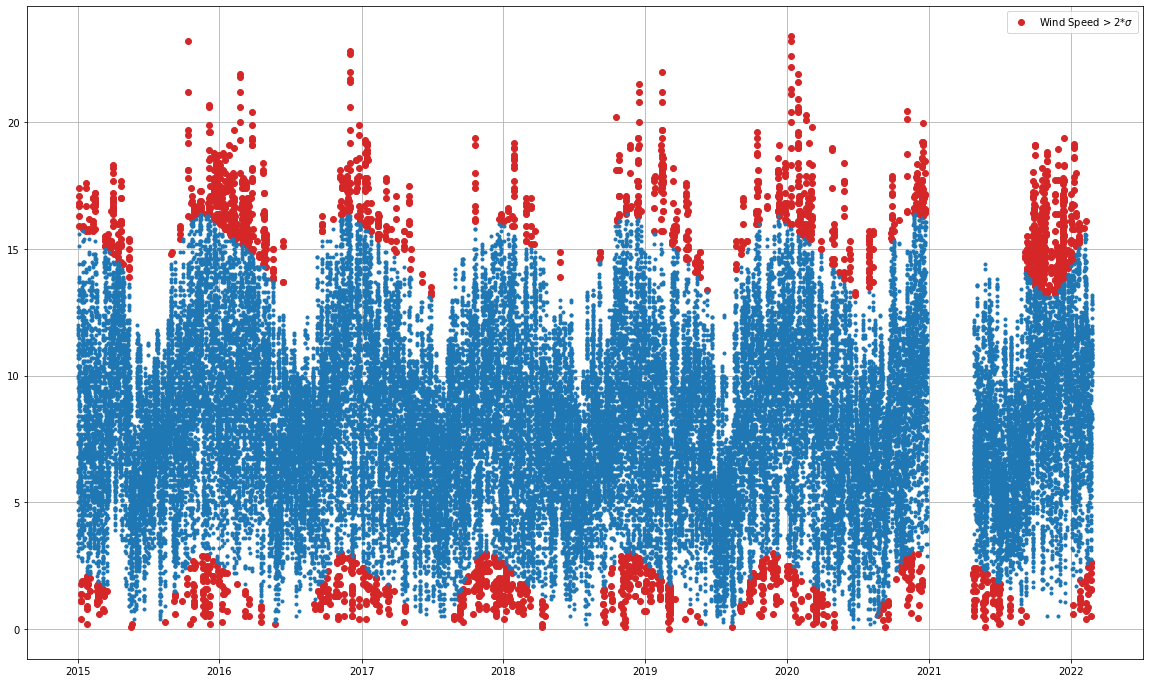

In [33]:
fig, ax = plt.subplots(figsize=(20, 12))

ax.plot(wind_speed[wind_flag == 3].time, wind_speed[wind_flag == 3], marker="o", linestyle="", color="tab:red")
ax.plot(wind_speed[wind_flag == 1].time, wind_speed[wind_flag == 1], marker=".", linestyle="", color="tab:blue")
ax.legend(["Wind Speed > 2*$\sigma$"])
ax.grid()

Lastly, select the wind data from 2015 onwards

In [47]:
wind_speed.sel(time=slice("2015","2022"))

<xarray.DataArray 'WS_401' (time: 59605)>
array([10.7     , 10.      , 10.4     , ..., 12.617845, 12.924783,
       12.84134 ], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2015-01-01 2015-01-01T01:00:00 ... 2022-02-25
    depth    float32 -4.0
    lat      float32 50.1
    lon      float32 215.1
Attributes:
    name:            WS
    long_name:       WIND SPEED (M/S)
    generic_name:     
    FORTRAN_format:   
    units:           m s-1
    epic_code:       401

### PMEL Carbon Data
Next, we want to load the surface seawater pH as recorded by NOAA PMEL's surface buoy.

In [15]:
# Load all the available carbon datasets
carbon = pd.DataFrame()
for file in os.listdir("../data/PMEL/OCADS/"):
    if file.endswith(".csv") and "QFLog" not in file:
        carbon = carbon.append(pd.read_csv(f"../data/PMEL/OCADS/{file}", header=4) )
        
# Clean up the date and time and merge into a single timestamp
carbon["Date"] = carbon["Date"].apply(lambda x: pd.to_datetime(x).strftime("%Y-%m-%d"))
carbon["Time"] = carbon["Time"].apply(lambda x: pd.to_datetime(x).strftime("%H:%M:%S"))
carbon["Timestamp"] = carbon["Date"] + "T" + carbon["Time"]
carbon["Timestamp"] = carbon["Timestamp"].apply(lambda x: pd.to_datetime(x))
carbon = carbon.sort_values(by="Timestamp")

# Drop carbon data that is missing
carbon["pH (total scale)"][carbon["pH (total scale)"] == -999.0] = np.nan

carbon.head()

,Mooring Name,Latitude,Longitude,Date,Time,xCO2 SW (wet) (umol/mol),CO2 SW QF,H2O SW (mmol/mol),xCO2 Air (wet) (umol/mol),CO2 Air QF,...,xCO2 Air (wet) (umol/mol),Licor Atm Pressure (hPa),xCO2 SW (dry) (umol/mol),xCO2 Air (dry) (umol/mol),fCO2 SW (sat) uatm,fCO2 Air (sat) uatm,pCO2 SW (sat) uatm,pCO2 Air (sat) uatm,pH SW,Timestamp
0,PAPA_145W_50N,50.12,-144.832,2007-06-08,00:34:00,NaN,2,2.32,NaN,2,...,385.5,1009.4,370.4,386.4,363.9,379.7,365.4,381.2,-999.000,2007-06-08 00:34:00
1,PAPA_145W_50N,50.12,-144.832,2007-06-08,01:04:00,NaN,2,1.90,NaN,2,...,386.3,1009.1,371.1,387.0,364.5,380.2,366.0,381.6,8.086,2007-06-08 01:04:00
2,PAPA_145W_50N,50.12,-144.832,2007-06-08,01:34:00,NaN,2,1.80,NaN,2,...,386.5,1008.9,371.2,387.2,364.6,380.3,366.0,381.8,-999.000,2007-06-08 01:34:00
3,PAPA_145W_50N,50.12,-144.832,2007-06-08,02:04:00,NaN,2,1.83,NaN,2,...,386.7,1008.8,371.5,387.4,364.8,380.4,366.2,381.9,-999.000,2007-06-08 02:04:00
4,PAPA_145W_50N,50.12,-144.832,2007-06-08,02:34:00,NaN,2,1.85,NaN,2,...,386.9,1008.7,371.7,387.6,364.9,380.6,366.4,382.1,-999.000,2007-06-08 02:34:00


Plot the carbon pCO2 and pH data

Text(0, 0.5, 'Seawater pH [Total scale]')

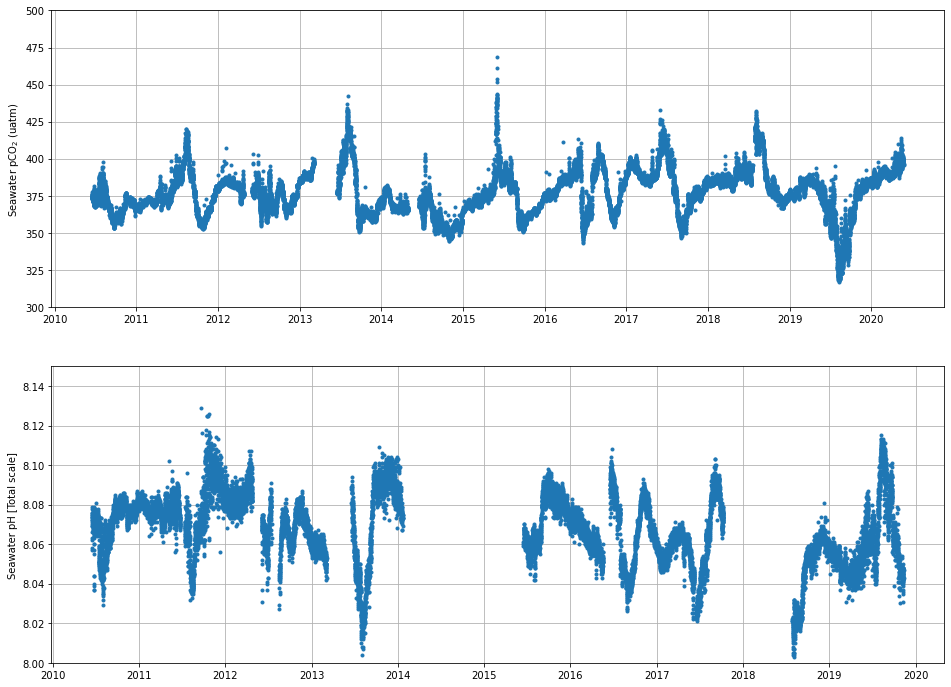

In [16]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(16, 12))

ax[0].plot(carbon["Timestamp"], carbon["pCO2 SW (sat) (uatm)"], marker=".", linestyle="")
ax[0].set_ylim((300, 500))
ax[0].grid()
ax[0].set_ylabel("Seawater pCO$_{2}$ (uatm)")

ax[1].plot(carbon["Timestamp"], carbon["pH (total scale)"], marker=".", linestyle="")
ax[1].set_ylim((8, 8.15))
ax[1].grid()
ax[1].set_ylabel("Seawater pH [Total scale]")

### OOI Flanking Mooring Data
Next, load the OOI Global Ocean Papa Flanking Moorings A & B pH data with associated deployment and annotation data, which is needed to further QC the data. The data was also processed using the ```Download_Data.ipynb``` jupyter notebook

In [17]:
flma = xr.open_dataset("../data/OOI/GP03FLMA-RIS01-04-PHSENF000_combined.nc")
flma_annotations = pd.read_csv("../data/OOI/GP03FLMA-RIS01-04-PHSENF000_annotations.csv")
flma_deployments = pd.read_csv("../data/OOI/GP03FLMA-RIS01-04-PHSENF000_deployments.csv")

In [18]:
flmb = xr.open_dataset("../data/OOI/GP03FLMB-RIS01-04-PHSENF000_combined.nc")
flmb_annotations = pd.read_csv("../data/OOI/GP03FLMB-RIS01-04-PHSENF000_annotations.csv")
flmb_deployments = pd.read_csv("../data/OOI/GP03FLMB-RIS01-04-PHSENF000_deployments.csv")

Plot the Flanking Moorings A & B pH Data, flagging the identified bad data

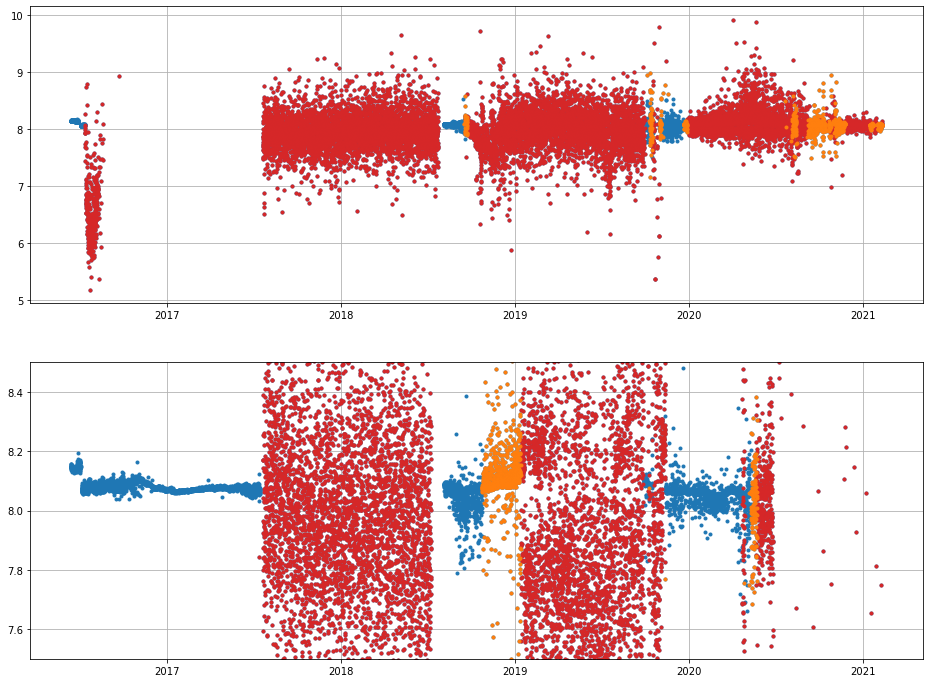

In [19]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(16, 12))

ax[0].plot(flma["time"], flma["seawater_ph"], marker=".", linestyle="")
ax[0].plot(flma["time"].where(flma.seawater_ph_quality_flag == 4), 
           flma["seawater_ph"].where(flma.seawater_ph_quality_flag == 4),
           marker=".", color="tab:red", linestyle="")
ax[0].plot(flma["time"].where(flma.seawater_ph_quality_flag == 3), 
           flma["seawater_ph"].where(flma.seawater_ph_quality_flag == 3),
           marker=".", color="tab:orange", linestyle="")
#ax[0].set_ylim((300, 500))
ax[0].grid()

ax[1].plot(flmb["time"], flmb["seawater_ph"], marker=".", linestyle="")
ax[1].plot(flmb["time"].where(flmb.seawater_ph_quality_flag == 4), 
           flmb["seawater_ph"].where(flmb.seawater_ph_quality_flag == 4),
           marker=".", color="tab:red", linestyle="")
ax[1].plot(flmb["time"].where(flmb.seawater_ph_quality_flag == 3), 
           flmb["seawater_ph"].where(flmb.seawater_ph_quality_flag == 3),
           marker=".", color="tab:orange", linestyle="")
ax[1].set_ylim((7.5, 8.5))
ax[1].grid()

Drop the bad data from the Papa Flanking Mooring PHSENS

In [20]:
flma_good = flma.where(flma.seawater_ph_quality_flag != 4, drop=True)
flmb_good = flmb.where(flmb.seawater_ph_quality_flag != 4, drop=True)

Plot the "good" Flanking Mooring pH Data

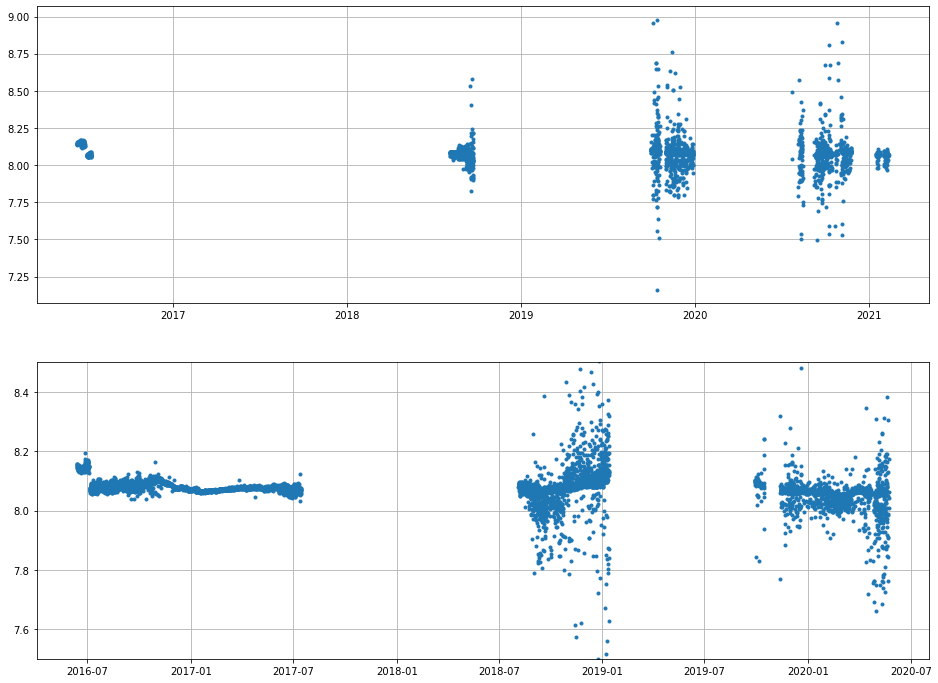

In [21]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(16, 12))

ax[0].plot(flma_good["time"], flma_good["seawater_ph"], marker=".", linestyle="")
ax[0].grid()

ax[1].plot(flmb_good["time"], flmb_good["seawater_ph"], marker=".", linestyle="")

ax[1].set_ylim((7.5, 8.5))
ax[1].grid()

Resample the good data to 6-hour averages

In [22]:
# Resample the good data
flma_6hr = flma_good.resample(time="6H").mean(skipna=True)
flmb_6hr = flmb_good.resample(time="6H").mean(skipna=True)

In [46]:
flma_flort = xr.open_dataset("../data/OOI/GP03FLMA-RIS01-05-FLORTD000_combined.nc")
flmb_flort = xr.open_dataset("../data/OOI/GP03FLMB-RIS01-05-FLORTD000_combined.nc")
flma_flort = flma_flort.sel(time=slice("2015","2022"))
flmb_flort = flmb_flort.sel(time=slice("2015","2022"))

### Bottle Data
Next, we need to load the Bottle Data. The bottle data has already been cleaned and processed using the ```Bottle_Data.ipynb``` jupyter notebook.

In [40]:
bottle_data = pd.DataFrame()
for file in sorted(os.listdir("../data/OOI/Ship_Data/")):
    if "_pH" in file:
        bottle_data = bottle_data.append(pd.read_csv("../data/OOI/Ship_Data/" + file), ignore_index=True)
        
bottle_data.head()

,Cruise,Station,Target Asset,Start Latitude [degrees],Start Longitude [degrees],Start Time [UTC],Cast,Cast Flag,Bottom Depth at Start Position [m],CTD File,...,Calculated Omega-C,Calculated Omega-A,CTD Absolute Salinity [g/kg],CTD Conservative Temperature,CTD Density [kg/m^3],CTD Sigma [kg/m^3],Calculated pH [lab conditions],Comments,Chlorophyll Comments,Calculated pCO2 [lab conditions]
0,MV1309,1.0,CTDMO cal/val & Release Testing\t,49.532333,-135.051,2013-07-17 19:31:24+00:00,1.0,*0000000000000100,3635.0,MV1309_CTD01.hex,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,MV1309,1.0,CTDMO cal/val & Release Testing\t,49.532333,-135.051,2013-07-17 19:31:24+00:00,1.0,*0000000000000100,3635.0,MV1309_CTD01.hex,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,MV1309,1.0,CTDMO cal/val & Release Testing\t,49.532333,-135.051,2013-07-17 19:31:24+00:00,1.0,*0000000000000100,3635.0,MV1309_CTD01.hex,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,MV1309,1.0,CTDMO cal/val & Release Testing\t,49.532333,-135.051,2013-07-17 19:31:24+00:00,1.0,*0000000000000100,3635.0,MV1309_CTD01.hex,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,MV1309,1.0,CTDMO cal/val & Release Testing\t,49.532333,-135.051,2013-07-17 19:31:24+00:00,1.0,*0000000000000100,3635.0,MV1309_CTD01.hex,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Select only the bottle samples which have pH data, and limit those samples to those shallower than 40 m depth

In [41]:
carbon_data = bottle_data.dropna(subset="Calculated pH")
carbon_data["CTD Bottle Closure Time [UTC]"] = carbon_data["CTD Bottle Closure Time [UTC]"].apply(lambda x: pd.to_datetime(x))
mask = carbon_data["CTD Pressure [db]"] < 40
carbon_data[mask].head()

#### Plot the figure
For plotting, we're going to use ```cmocean``` package to get the colormap for the Cholorophyll concentrations

In [48]:
import cmocean

Text(0.5, 0, 'Chlorophyll-a [ug/L]')

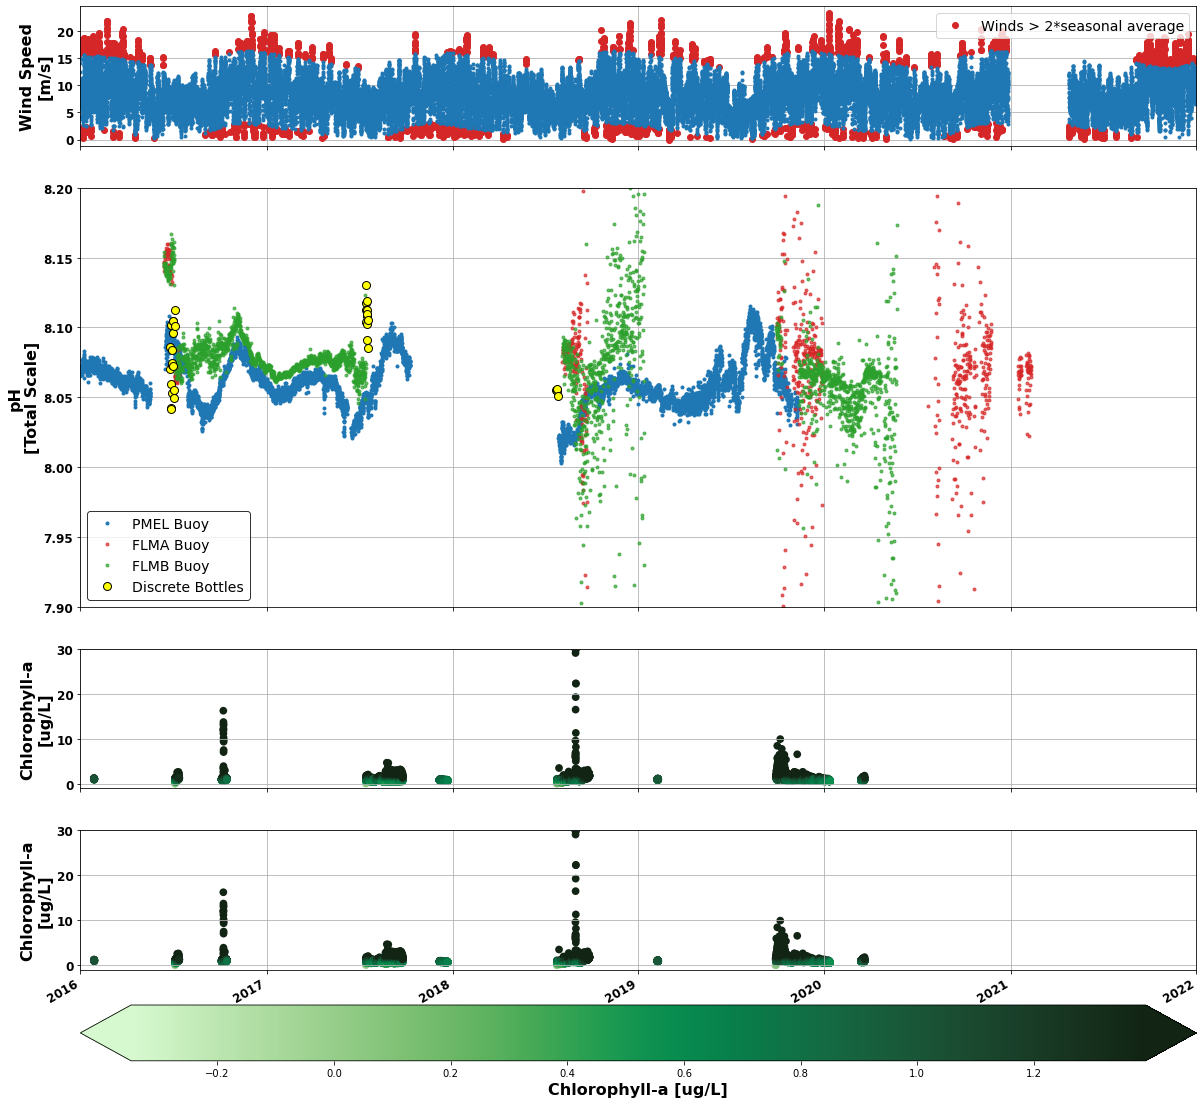

In [49]:
fig, ax = plt.subplots(nrows = 4, ncols = 1, gridspec_kw={'height_ratios': [1, 3, 1, 1]}, figsize=(20, 24), sharex=True)

# Plot the wind speeds
ax[0].plot(wind_speed[wind_flag == 3].time, wind_speed[wind_flag == 3], marker="o", linestyle="", color="tab:red")
ax[0].plot(wind_speed[wind_flag == 1].time, wind_speed[wind_flag == 1], marker=".", linestyle="", color="tab:blue")
ax[0].grid()
ax[0].set_ylabel("Wind Speed\n[m/s]", fontsize=16, weight="bold")
ax[0].legend(["Winds > 2*seasonal average"], fontsize=14)
#ax[0].set_title("NOAA PMEL Met Buoy", fontsize=16, weight="bold")

for tick in ax[0].yaxis.get_major_ticks():
    tick.label1.set_fontsize(12)
    tick.label1.set_fontweight("bold")

ax[1].plot(carbon["Timestamp"][carbon["Timestamp"] > pd.to_datetime("2015")], carbon["pH (total scale)"][carbon["Timestamp"] > pd.to_datetime("2015")], color="tab:blue", marker=".", linestyle="", label="PMEL Buoy")
ax[1].plot(flma_6hr["time"], flma_6hr["seawater_ph"], marker=".", linestyle="", color="tab:red", label="FLMA Buoy", alpha=0.7)
ax[1].plot(flmb_6hr["time"], flmb_6hr["seawater_ph"], marker=".", linestyle="", color="tab:green", label="FLMB Buoy", alpha=0.7)
ax[1].plot(carbon_data["CTD Bottle Closure Time [UTC]"][mask], carbon_data["Calculated pH"][mask], color="yellow",
        marker="o", markersize=8, markeredgecolor="black", linestyle = "", label="Discrete Bottles")
#ax[1].set_title("NOAA PMEL & OOI Flanking Moorings", fontsize=16, weight="bold")


ax[1].grid()
ax[1].set_xlabel("Time", fontsize=16, weight="bold")
ax[1].set_ylabel("pH\n[Total Scale]", fontsize=16, weight="bold")
ax[1].set_xlim((pd.to_datetime("2016"), pd.to_datetime("2022")))
ax[1].set_ylim((7.9, 8.2))

ax[1].legend(fontsize=14, edgecolor="black", loc="lower left")
fig.autofmt_xdate()

for tick in ax[1].xaxis.get_major_ticks():
    tick.label1.set_fontsize(12)
    tick.label1.set_fontweight("bold")
    
for tick in ax[1].yaxis.get_major_ticks():
    tick.label1.set_fontsize(12)
    tick.label1.set_fontweight("bold")
    
# Plot the FLMA
kw0 = dict(s=60, c=flma_flort["fluorometric_chlorophyll_a"].values, cmap=cmocean.cm.algae, 
           marker="o", edgecolor="none", vmax=1.391500)
cs0 = ax[2].scatter(flma_flort.time.values, flma_flort.fluorometric_chlorophyll_a.values, **kw0)
ax[2].set_ylim((-1.0, 30))
ax[2].grid()
ax[2].set_ylabel("Chlorophyll-a\n[ug/L]", fontsize=16, weight="bold")
#ax[2].set_title("OOI Flanking Mooring A at 30 m Depth", fontsize=16, weight="bold")
for tick in ax[2].yaxis.get_major_ticks():
    tick.label1.set_fontsize(12)
    tick.label1.set_fontweight("bold")

# Plot the FLMB
kw1 = dict(s=60, c=flmb_flort["fluorometric_chlorophyll_a"].values, cmap=cmocean.cm.algae,
           marker="o", edgecolor="none", vmax=1.391500)
cs1 = ax[3].scatter(flmb_flort.time.values, flmb_flort.fluorometric_chlorophyll_a.values, **kw1)
ax[3].set_ylim((-1.0, 30))
ax[3].grid()
ax[3].set_ylabel("Chlorophyll-a\n[ug/L]", fontsize=16, weight="bold")
#ax[3].set_title("OOI Flanking Mooring B at 30 m Depth", fontsize=16, weight="bold")

for tick in ax[3].yaxis.get_major_ticks():
    tick.label1.set_fontsize(12)
    tick.label1.set_fontweight("bold")
for tick in ax[3].xaxis.get_major_ticks():
    tick.label1.set_fontsize(12)
    tick.label1.set_fontweight("bold")

# Add the colorbar
cbar = fig.colorbar(cs1, ax=ax.ravel().tolist(), orientation='horizontal', extend='both', pad=0.03)
cbar.ax.set_xlabel("Chlorophyll-a [ug/L]", fontsize=16, weight="bold")
#ax[2].set_ylabel('Depth (m)', fontsize=14, weight="bold");

In [ ]:
fig.savefig("../documents/bio_physics.png", transparent=False, facecolor="white")

---
## Figure 3: Dissolved Oxygen
Dissolved oxygen concentrations collected by the OOI Flanking Mooring A (top), Flanking Mooring B (middle), and the top 500 meters of the Upper Wire Following Profiler (bottom) on the Global Hybrid Wire-Following-Profiler mooring.

#### Load the Profiler Data

In [53]:
hypm_oxygen = xr.open_dataset("../data/OOI/GP02HYPM-WFP02-03-DOSTAL000_data.nc")
hypm_oxygen

<xarray.Dataset>
Dimensions:                                     (time: 2305429)
Coordinates:
    lon                                         (time) float64 ...
    lat                                         (time) float64 ...
    depth                                       (time) float64 ...
  * time                                        (time) datetime64[ns] 2013-07...
Data variables: (12/15)
    practical_salinity                          (time) float64 ...
    estimated_oxygen_concentration_qc_executed  (time) float32 ...
    dissolved_oxygen_qc_executed                (time) float32 ...
    internal_timestamp                          (time) datetime64[ns] ...
    optode_temperature_qc_executed              (time) float32 ...
    ctdpf_ckl_seawater_temperature              (time) float64 ...
    ...                                          ...
    estimated_oxygen_concentration              (time) float32 ...
    optode_temperature                          (time) float32 ...
    estimated_oxygen_concentration_qc_results   (time) float32 ...
    int_ctd_pressure                            (time) float64 ...
    wfp_timestamp                               (time) datetime64[ns] ...
    dissolved_oxygen                            (time) float64 ...
Attributes: (12/68)
    node:                               WFP02
    comment:                            Data collected from the OOI M2M API a...
    publisher_email:                    
    sourceUrl:                          http://oceanobservatories.org/
    collection_method:                  recovered_wfp
    stream:                             dosta_ln_wfp_instrument_recovered
    ...                                 ...
    geospatial_lon_units:               degrees_east
    geospatial_lon_resolution:          0.1
    geospatial_vertical_units:          meters
    geospatial_vertical_resolution:     0.1
    geospatial_vertical_positive:       down
    Location_name:                      Global Station Papa Apex Profiler Moo...

Select only the profiler data less than 500 m depth (due to size constraints)

In [54]:
subset = hypm_oxygen.where(hypm_oxygen.depth <= 500, drop=True)
subset = subset.dropna(dim="time")
subset

<xarray.Dataset>
Dimensions:                                     (time: 445807)
Coordinates:
    lon                                         (time) float64 -144.8 ... -144.9
    lat                                         (time) float64 50.07 ... 50.12
    depth                                       (time) float64 499.0 ... 339.9
  * time                                        (time) datetime64[ns] 2013-07...
Data variables: (12/15)
    practical_salinity                          (time) float64 34.09 ... 33.92
    estimated_oxygen_concentration_qc_executed  (time) float32 9.0 9.0 ... 9.0
    dissolved_oxygen_qc_executed                (time) float32 29.0 ... 29.0
    internal_timestamp                          (time) datetime64[ns] 2013-07...
    optode_temperature_qc_executed              (time) float32 29.0 ... 29.0
    ctdpf_ckl_seawater_temperature              (time) float64 3.769 ... 4.183
    ...                                          ...
    estimated_oxygen_concentration              (time) float32 39.08 ... 75.77
    optode_temperature                          (time) float32 3.758 ... 4.158
    estimated_oxygen_concentration_qc_results   (time) float32 9.0 9.0 ... 9.0
    int_ctd_pressure                            (time) float64 503.9 ... 343.2
    wfp_timestamp                               (time) datetime64[ns] 2013-07...
    dissolved_oxygen                            (time) float64 30.77 ... 59.47
Attributes: (12/68)
    node:                               WFP02
    comment:                            Data collected from the OOI M2M API a...
    publisher_email:                    
    sourceUrl:                          http://oceanobservatories.org/
    collection_method:                  recovered_wfp
    stream:                             dosta_ln_wfp_instrument_recovered
    ...                                 ...
    geospatial_lon_units:               degrees_east
    geospatial_lon_resolution:          0.1
    geospatial_vertical_units:          meters
    geospatial_vertical_resolution:     0.1
    geospatial_vertical_positive:       down
    Location_name:                      Global Station Papa Apex Profiler Moo...

Replace obviously bad data with NaNs

In [55]:
subset["dissolved_oxygen"][subset["dissolved_oxygen"] < 0] = np.nan

#### Load Flanking Mooring oxygen data

In [56]:
flma_dosta = xr.open_dataset("../data/OOI/GP03FLMA-RIS01-03-DOSTAD000_combined.nc")
flmb_dosta = xr.open_dataset("../data/OOI/GP03FLMB-RIS01-03-DOSTAD000_combined.nc")

#### Plot the figure

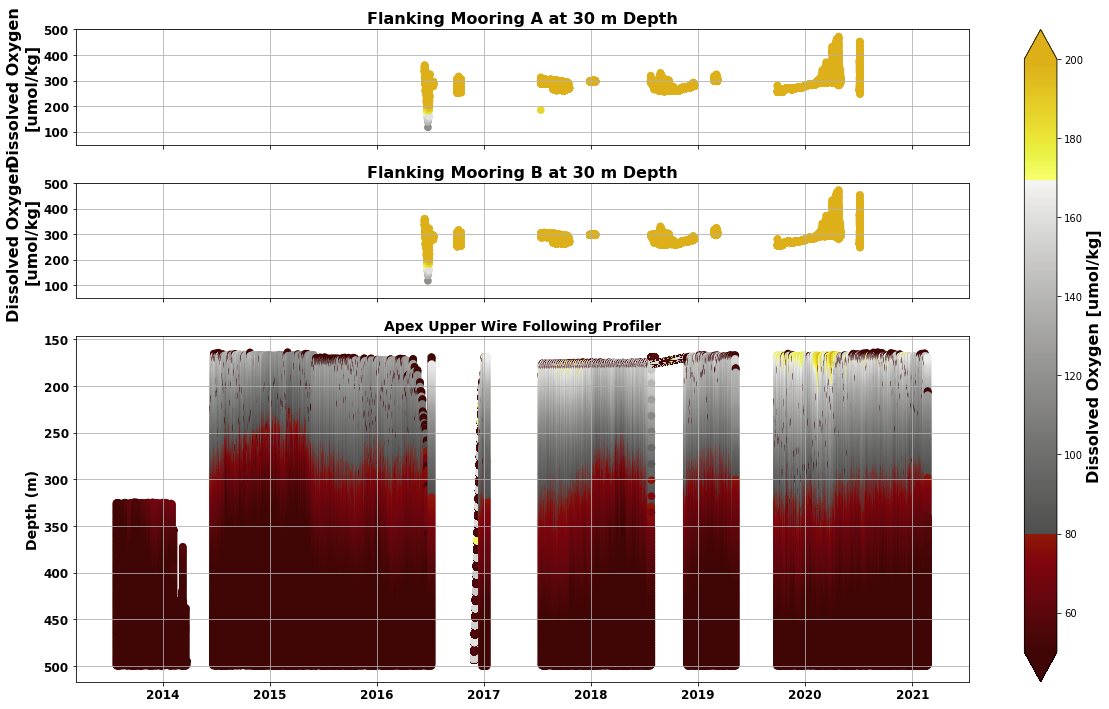

In [57]:
fig, ax = plt.subplots(nrows=3, ncols=1, gridspec_kw={'height_ratios': [1, 1, 3]}, figsize=(20, 12), sharex=True)

# Plot the FLMA
kw0 = dict(s=60, c=flma_dosta["dissolved_oxygen"].values, cmap=cmocean.cm.oxy, 
           marker="o", edgecolor="none", vmin=50, vmax=200)
cs0 = ax[0].scatter(flma_dosta.time.values, flma_dosta.dissolved_oxygen.values, **kw0)
ax[0].set_ylim((50, 500))
ax[0].grid()
ax[0].set_ylabel("Dissolved Oxygen\n[umol/kg]", fontsize=16, weight="bold")
ax[0].set_title("Flanking Mooring A at 30 m Depth", fontsize=16, weight="bold")
for tick in ax[0].yaxis.get_major_ticks():
    tick.label1.set_fontsize(12)
    tick.label1.set_fontweight("bold")

# Plot the FLMB
kw1 = dict(s=60, c=flmb_dosta["dissolved_oxygen"].values, marker="o", cmap=cmocean.cm.oxy,
           edgecolor="none", vmin=50, vmax=200)
cs1 = ax[1].scatter(flmb_dosta.time.values, flmb_dosta.dissolved_oxygen.values, **kw1)
ax[1].set_ylim((50, 500))
ax[1].grid()
ax[1].set_ylabel("Dissolved Oxygen\n[umol/kg]", fontsize=16, weight="bold")
ax[1].set_title("Flanking Mooring B at 30 m Depth", fontsize=16, weight="bold")
for tick in ax[1].yaxis.get_major_ticks():
    tick.label1.set_fontsize(12)
    tick.label1.set_fontweight("bold")


# Plot the profiler
kw2 = dict(s=60, c=subset["dissolved_oxygen"].values, marker="o", cmap=cmocean.cm.oxy,
           edgecolor="none", vmin=50, vmax=200)
cs2 = ax[2].scatter(subset.time.values, subset.depth.values, **kw2)

#ax.set_ylim((150, 500))
ax[2].invert_yaxis()
ax[2].grid()
ax[2].set_title("Apex Upper Wire Following Profiler", fontsize=14, weight="bold")
for tick in ax[2].yaxis.get_major_ticks():
    tick.label1.set_fontsize(12)
    tick.label1.set_fontweight("bold")
    
for tick in ax[2].xaxis.get_major_ticks():
    tick.label1.set_fontsize(12)
    tick.label1.set_fontweight("bold")
    
cbar = fig.colorbar(cs2, ax=ax.ravel().tolist(), orientation='vertical', extend='both')
cbar.ax.set_ylabel('Dissolved Oxygen [umol/kg]', fontsize=16, weight="bold")
ax[2].set_ylabel('Depth (m)', fontsize=14, weight="bold");

fig.autofmt_xdate()

In [ ]:
fig.savefig("../documents/papa_oxygen.png", transparent=False, facecolor="white")

---
## Figure 2: Temperature-Salinity Diagrams
The Temperature-Salinity diagrams with pressure from the Upper Wire Following Profiler are divided by season. The plots of potential density are generated using the ```gsw``` package which is the Python implementation of the Gibbs SeaWater (GSW) Oceanographic Toolbox of TEOS-10.

#### First, split the profiler data based on season.

In [58]:
hypm_winter = hypm_oxygen.where(hypm_oxygen["time.season"] == "DJF", drop=True)
hypm_spring = hypm_oxygen.where(hypm_oxygen["time.season"] == "MAM", drop=True)
hypm_summer = hypm_oxygen.where(hypm_oxygen["time.season"] == "JJA", drop=True)
hypm_autumn = hypm_oxygen.where(hypm_oxygen["time.season"] == "SON", drop=True)

#### Make the figure

Text(0, 0.5, 'Pressure [dbar]')

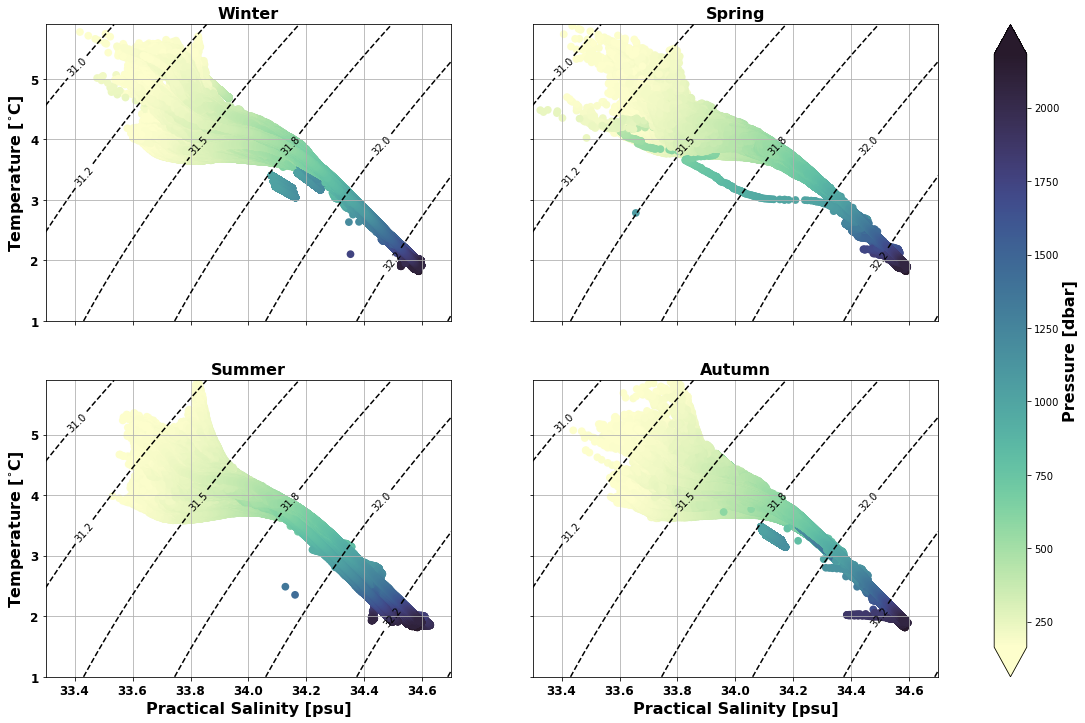

In [61]:
import gsw

# Generate the contours of potential density
# Use ranges for T from 1 to 6 degrees, S from 33.3 to 34.7
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20, 12), sharex=True, sharey=True)

# Generate the density contours
t = np.arange(1, 6, 0.1)
s = np.arange(33.3, 34.7, 0.1)
T, S = np.meshgrid(t, s)
SA = gsw.SA_from_SP(S, 1000, -144.84, 50.09)
CT = gsw.CT_from_t(SA, T, 1000)
SIGMA = gsw.sigma1(SA, CT)

# Plot winter
ts00 = ax[0][0].contour(S, T, SIGMA, colors='black', linestyles='dashed')
ax[0][0].clabel(ts00, inline=1, fontsize=10, fmt='%1.1f')
kw00 = dict(s=60, c=hypm_winter["depth"].values, marker="o", edgecolor="none", cmap=cmocean.cm.deep)#, vmin=50, vmax=200)
cs00 = ax[0][0].scatter(hypm_winter.practical_salinity, hypm_winter.ctdpf_ckl_seawater_temperature, **kw00)
ax[0][0].set_ylabel("Temperature [$^{\circ}$C]", fontsize=16, weight="bold")
ax[0][0].set_title("Winter", fontsize=16, weight="bold")
ax[0][0].grid()

for tick in ax[0][0].yaxis.get_major_ticks():
    tick.label1.set_fontsize(12)
    tick.label1.set_fontweight("bold")

# Plot spring
ts01 = ax[0][1].contour(S, T, SIGMA, colors='black', linestyles='dashed')
ax[0][1].clabel(ts01, inline=1, fontsize=10, fmt='%1.1f')
kw01 = dict(s=60, c=hypm_spring["depth"].values, marker="o", edgecolor="none", cmap=cmocean.cm.deep)
cs01 = ax[0][1].scatter(hypm_spring.practical_salinity, hypm_spring.ctdpf_ckl_seawater_temperature, **kw01)
ax[0][1].set_title("Spring", fontsize=16, weight="bold")
ax[0][1].grid()

# Plot summer
ts10 = ax[1][0].contour(S, T, SIGMA, colors='black', linestyles='dashed')
ax[1][0].clabel(ts10, inline=1, fontsize=10, fmt='%1.1f')
kw10 = dict(s=60, c=hypm_summer["depth"].values, marker="o", edgecolor="none", cmap=cmocean.cm.deep)
cs10 = ax[1][0].scatter(hypm_summer.practical_salinity, hypm_summer.ctdpf_ckl_seawater_temperature, **kw10)
ax[1][0].set_xlabel("Practical Salinity [psu]", fontsize=16, weight="bold")
ax[1][0].set_ylabel("Temperature [$^{\circ}$C]", fontsize=16, weight="bold")
ax[1][0].set_title("Summer", fontsize=16, weight="bold")
ax[1][0].grid()

for tick in ax[1][0].yaxis.get_major_ticks():
    tick.label1.set_fontsize(12)
    tick.label1.set_fontweight("bold")
for tick in ax[1][0].xaxis.get_major_ticks():
    tick.label1.set_fontsize(12)
    tick.label1.set_fontweight("bold")

# Plot fall
ts11 = ax[1][1].contour(S, T, SIGMA, colors='black', linestyles='dashed')
ax[1][1].clabel(ts11, inline=1, fontsize=10, fmt='%1.1f')
kw11 = dict(s=60, c=hypm_autumn["depth"].values, marker="o", edgecolor="none", cmap=cmocean.cm.deep)
cs11 = ax[1][1].scatter(hypm_autumn.practical_salinity, hypm_autumn.ctdpf_ckl_seawater_temperature, **kw11)
ax[1][1].set_xlabel("Practical Salinity [psu]", fontsize=16, weight="bold")
ax[1][1].set_title("Autumn", fontsize=16, weight="bold")
ax[1][1].grid()

for tick in ax[1][1].xaxis.get_major_ticks():
    tick.label1.set_fontsize(12)
    tick.label1.set_fontweight("bold")

cbar = fig.colorbar(cs11, ax=ax.ravel().tolist(), orientation='vertical', extend='both')
cbar.ax.set_ylabel('Pressure [dbar]', fontsize=16, weight="bold")

In [ ]:
fig.savefig("../documents/TS_pressure.png", transparent=False, facecolor="white")